# Download BRDC

In [1]:
from Downloading.downloading_brdc import DownloadBrdc
from datetime import datetime
import pandas as pd
import numpy as np
from pathlib import Path

## Download

brdc_date = datetime(2021, 1, 1)
download_dir = Path(r"F:\brdc_test")
local_file_path = DownloadBrdc(brdc_date, download_dir).download()

File F:\brdc_test\BRDC00IGS_R_20210010000_01D_MN.rnx.gz already exists


In [2]:

## Read

from Readers import ReadBRDC
brdc_arrays = ReadBRDC(local_file_path).read()

g_arr, r_arr, c_arr, e_arr, header = brdc_arrays

In [3]:
selData = g_arr[:,3:]

epoch = g_arr[:,0]
system = g_arr[:,1]
prn = g_arr[:,2]

bias      = selData[:,0]
drift     = selData[:,1]
driftRate = selData[:,2]
iode = selData[:,3]
crs       = selData[:,4]
delta_n    = selData[:,5]
mean_anomaly_0 = selData[:,6]
cuc       = selData[:,7]
e         = selData[:,8]
cus       = selData[:,9]
sqrt_a     = selData[:,10]
toe_sow   = selData[:,11]
cic       = selData[:,12]
omega_0    = selData[:,13]
cis       = selData[:,14]
i_0        = selData[:,15]
crc       = selData[:,16]
omega     = selData[:,17]
omega_dot  = selData[:,18]
i_dot      = selData[:,19]

n = len(epoch)

In [4]:
import numpy as np

def newton_raphson_kepler(Mk, e, tolerance=1e-6, max_iterations=1000):
    """
    Solve the Kepler equation for the eccentric anomaly.

    Parameters:
    - Mk : float
        Mean anomaly in radians.
    - e : float
        Eccentricity of the orbit.
    - tolerance : float, optional
        The acceptable error between successive iterations (default is 1e-6).
    - max_iterations : int, optional
        Maximum number of iterations to perform (default is 1000).

    Returns:
    - Ek : float
        Eccentric anomaly in radians.
    """
    if Mk < 0 or Mk > 2 * np.pi:
        Mk = np.mod(Mk, 2 * np.pi)  # Normalize Mk to be within 0 and 2*pi
    
    # Initial guess for E_k can be Mk itself
    Ek = Mk

    for _ in range(max_iterations):
        Ek_next = Ek - (Ek - e * np.sin(Ek) - Mk) / (1 - e * np.cos(Ek))
        if abs(Ek_next - Ek) < tolerance:
            return Ek_next
        Ek = Ek_next

    raise RuntimeError(f"Solution did not converge after {max_iterations} iterations.")

# Example usage:
Mk_example = np.pi / 6  # Example mean anomaly in


In [5]:
from GNSS import GPS
from Coord import rotation_matrices as rm
from time_transform.time_format import GpsTime
from datetime import timedelta

epoch_dt = [datetime.fromtimestamp(ux_ts) +timedelta(seconds=300) for ux_ts in epoch]

epoch_gpst = [GpsTime(dttt) for dttt in epoch_dt]

epoch_sow = np.array([dttt.GPSSOW  for dttt in epoch_gpst])


t_k = epoch_sow - toe_sow
# If t_k > 302400 sec, subtract 604800 from t_k. if t_k <-302400 add 604800 to t_k

mean_anomaly_k = mean_anomaly_0 + (np.sqrt(GPS.miu)/ sqrt_a**3 + delta_n) * t_k

# Eccentric Anomaly
# E_k = mean_anomaly_k + e * np.sin(mean_anomaly_k)
E_k = np.array([newton_raphson_kepler(Mk, e) for Mk, e in zip(mean_anomaly_k, e)])

# True Anomaly
v_k = np.arctan2(np.sqrt(1-e**2) * np.sin(E_k), np.cos(E_k) - e)

# Argument of Latitude
u_k = v_k + omega + cus * np.sin(2*(omega + v_k)) + cuc * np.cos(2*(omega + v_k))

# radial distance
r_k = sqrt_a**2 * (1 - e * np.cos(E_k)) + crc * np.cos(2*(omega + v_k)) + crs * np.sin(2*(omega + v_k))

# inclination
i_k = i_0 + i_dot * t_k + cic * np.cos(2*(omega + v_k)) + cis * np.sin(2*(omega + v_k))

# longtude of the ascending node
lambda_k = omega_0 + (omega_dot - GPS.rad) * t_k - (GPS.rad * toe_sow)

# lambda_k = lambda_k.reshape(1,-1)

zero_vec = np.zeros(n)

rk_vector = np.array([r_k, zero_vec, zero_vec])

rk_vector = rk_vector.T[:, :, np.newaxis]  # Final shape (n, 3, 1)

R3_lambda_k = rm.R3(-lambda_k)
R1_i_k = rm.R1(-i_k)
R3_u_k = rm.R3(-u_k)

R = R3_lambda_k @ R1_i_k @ R3_u_k

result = (R @ rk_vector).squeeze()

x_k, y_k, z_k = result.T


In [6]:
# calculate sp3 values to verify the results

from chc_modules.find_sv import FindSV

save_dir = Path(r"F:/test/brdc_calc_test")
save_dir.mkdir(exist_ok=True, parents=True)

process_date  = datetime(2021, 1, 1)
system = 'G'

finder = FindSV(process_date, system, save_dir, interval = 30)
finder.run()


Starting the workflow for 2021-01-01 00:00:00.
Beginning download process of SP3 files
Downloaded final SP3 files for 2020-12-31 00:00:00.
Downloaded final SP3 files for 2021-01-01 00:00:00.
Downloaded final SP3 files for 2021-01-02 00:00:00.
Beginning conversion process of SP3 to .npy
Read and saved SP3 file F:\test\brdc_calc_test\SP3\ESA0MGNFIN_20203660000_01D_05M_ORB.SP3 as a numpy array for 2021-01-01 00:00:00.
Read and saved SP3 file F:\test\brdc_calc_test\SP3\ESA0MGNFIN_20210010000_01D_05M_ORB.SP3 as a numpy array for 2021-01-01 00:00:00.
Read and saved SP3 file F:\test\brdc_calc_test\SP3\ESA0MGNFIN_20210020000_01D_05M_ORB.SP3 as a numpy array for 2021-01-01 00:00:00.
Beginning process of SP3 interpolation
Interpolated and saved SP3 for G on 2021-01-01.
Completed the Find SV for 2021-01-01 00:00:00.


In [7]:
# read svpos file

sv_pos_sp3 = np.load(r"F:\test\brdc_calc_test\SV_POS_NPY\svPos_2021_1_G.npy", allow_pickle=True).T

sp3_df = pd.DataFrame(sv_pos_sp3, columns=['SoD', 'sys', 'prn', 'x', 'y', 'z', ])


In [8]:
epoch_dt = [datetime.fromtimestamp(e) for e in epoch]

epoch_sod = [e.hour * 3600 + e.minute * 60 + e.second for e in epoch_dt]

brdc_df = pd.DataFrame(
    {
        'SoD': epoch_sod,
        'sys' : 1,
        'prn' : prn,
        'x' : x_k,
        'y' : y_k,
        'z' : z_k
    }
)

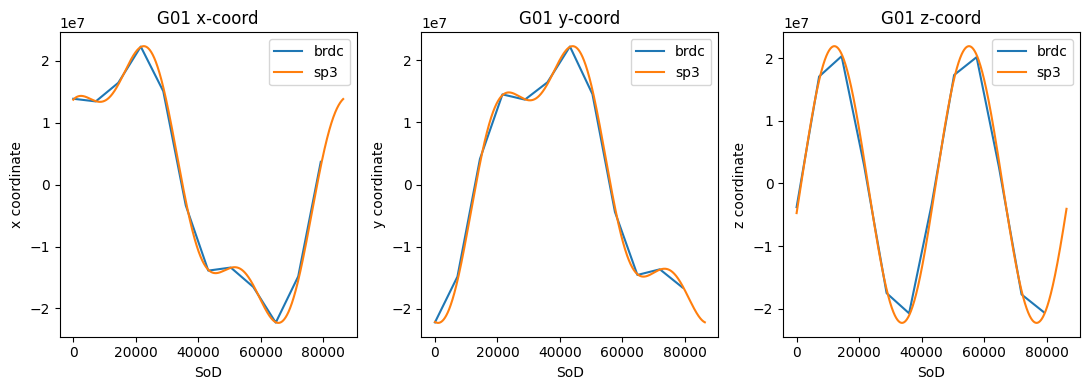

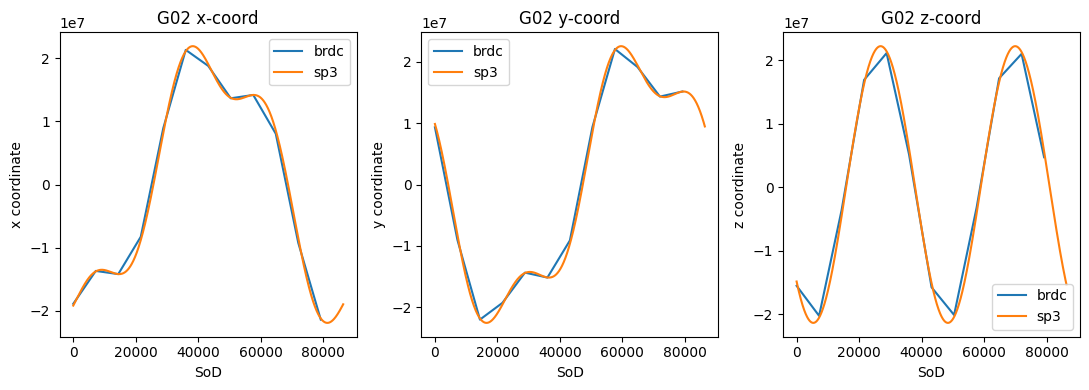

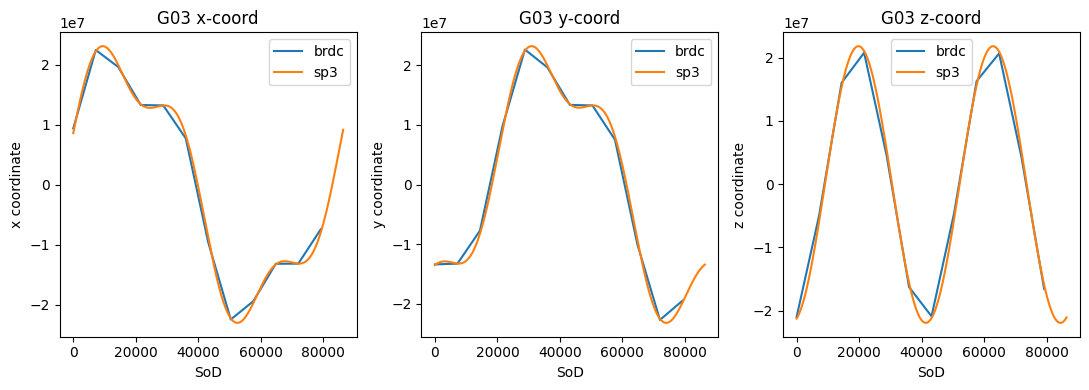

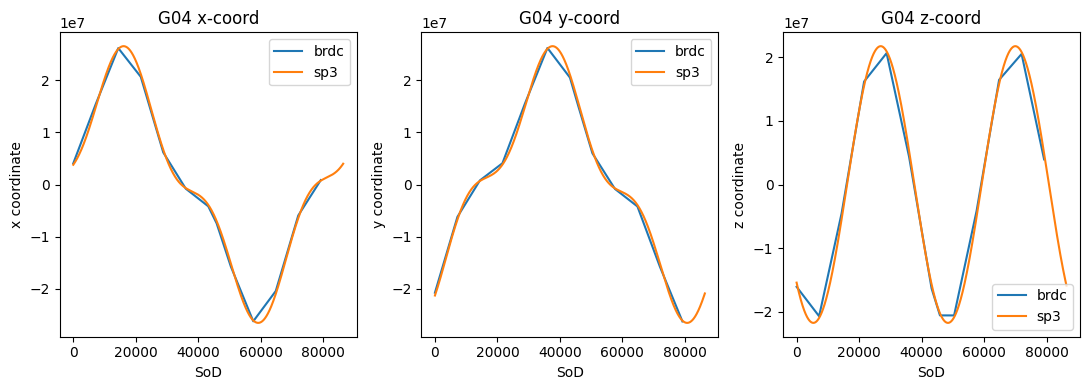

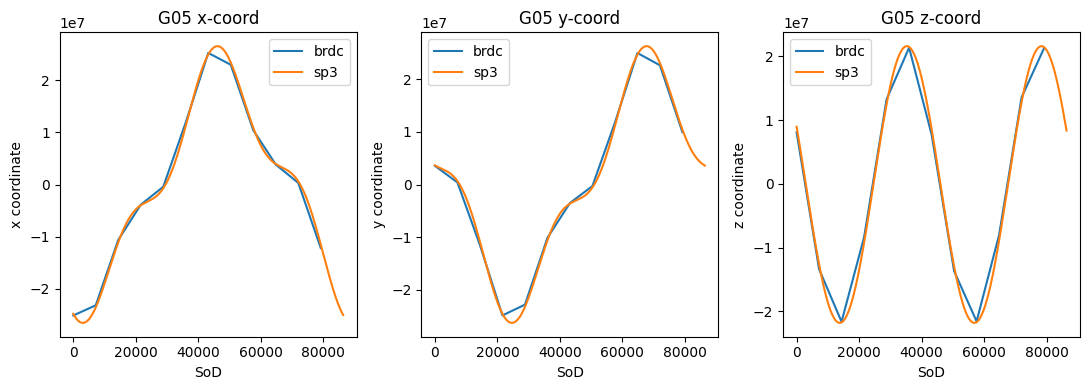

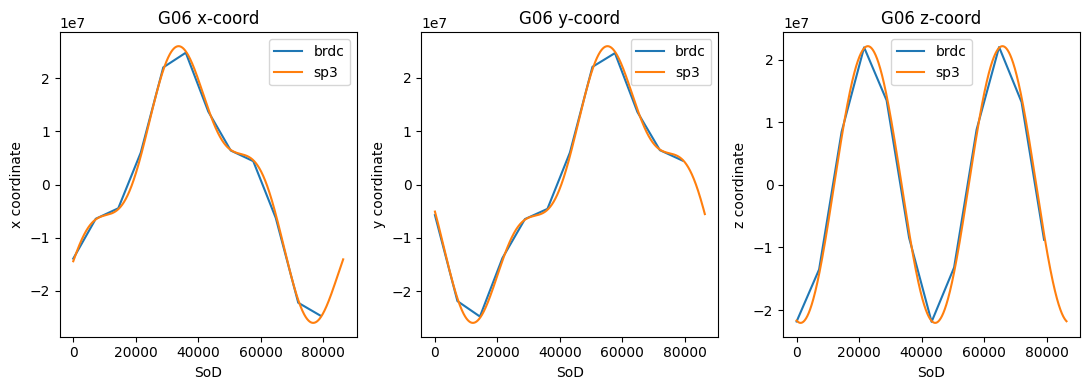

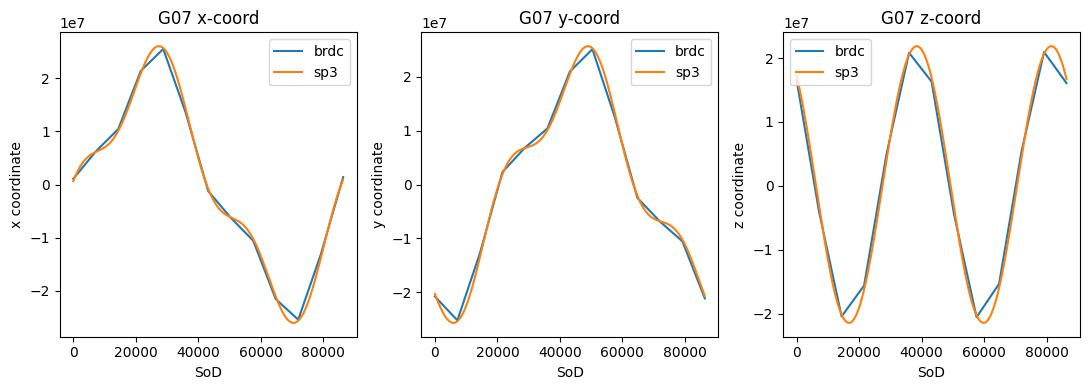

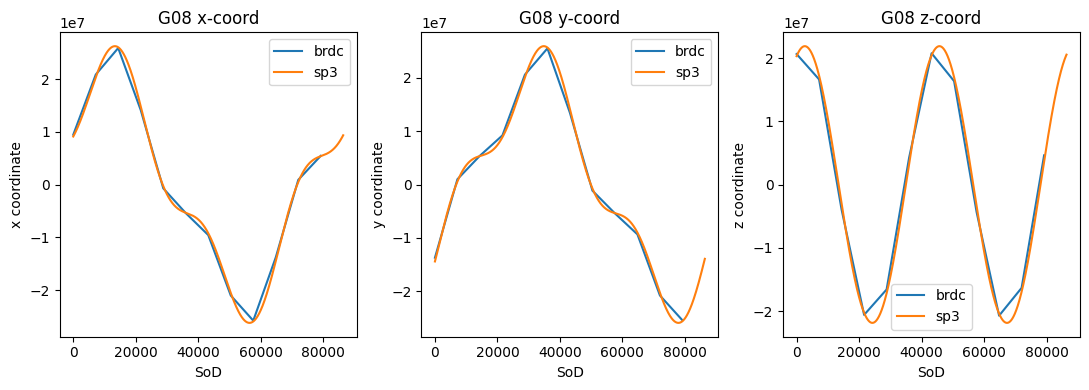

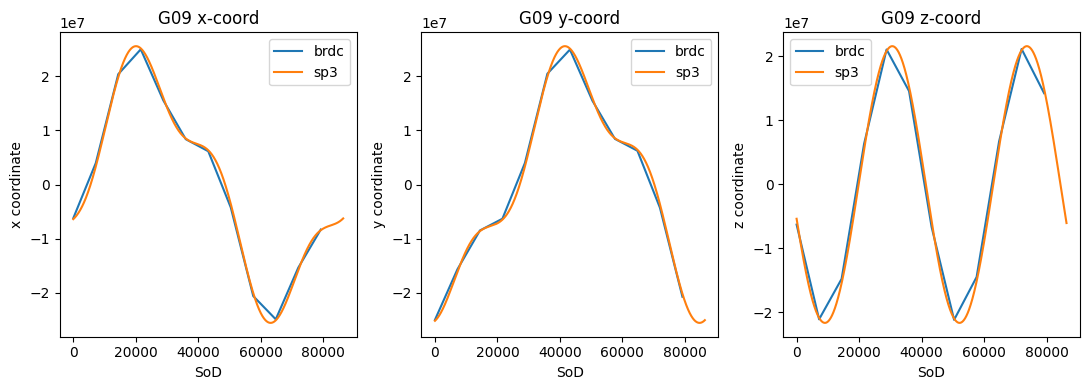

In [9]:
from matplotlib import pyplot as plt

for prn in range(1,10):

    brdc_plot_df = brdc_df[brdc_df['prn'] == prn]
    sp3_plot_df = sp3_df[sp3_df['prn'] == prn]


    fig, axs = plt.subplots(1, 3, figsize=(11, 4))  # Create 3 subplots arranged vertically

    # Plot x coordinates
    axs[0].plot(brdc_plot_df['SoD'], brdc_plot_df['x'], label='brdc')
    axs[0].plot(sp3_plot_df['SoD'], sp3_plot_df['x'], label='sp3')
    axs[0].set_xlabel('SoD')
    axs[0].set_ylabel('x coordinate')
    axs[0].set_title(f'G{prn:02d} x-coord')
    axs[0].legend()

    # Plot y coordinates
    axs[1].plot(brdc_plot_df['SoD'], brdc_plot_df['y'], label='brdc')
    axs[1].plot(sp3_plot_df['SoD'], sp3_plot_df['y'], label='sp3')
    axs[1].set_xlabel('SoD')
    axs[1].set_ylabel('y coordinate')
    axs[1].set_title(f'G{prn:02d} y-coord')
    axs[1].legend()

    # Plot z coordinates
    axs[2].plot(brdc_plot_df['SoD'], brdc_plot_df['z'], label='brdc')
    axs[2].plot(sp3_plot_df['SoD'], sp3_plot_df['z'], label='sp3')
    axs[2].set_xlabel('SoD')
    axs[2].set_ylabel('z coordinate')
    axs[2].set_title(f'G{prn:02d} z-coord')
    axs[2].legend()

    # Adjust layout so that titles and labels don't overlap
    plt.tight_layout()

    plt.show()

